In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import geemap
import ee
Map=geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [3]:
# 定义参数
region = 'tibet'
year = '2020'
startDate = year + '-01-01'
endDate = year + '-12-31'

In [4]:
# # 大庆市
# roi = ee.Geometry.Rectangle([123.9355, 45.8362,125.3055, 46.8762])
# # 天津市
# roi = ee.Geometry.Rectangle([115.9244, 38.6272,117.4944,39.6372])
# # 武汉市
# roi = ee.Geometry.Rectangle([113.7393, 29.8642,115.0993, 30.9242])
# # 珠三角
# roi = ee.Geometry.Rectangle([112.7614, 22.2347,114.0514, 23.2547])
# 青藏高原
roi = ee.Geometry.Rectangle([89.8826, 34.6579,91.3626, 35.8279])
Map.addLayer(roi, {}, "roi")
Map.centerObject(roi,7)

In [5]:
## 指数的计算
def water_index(img):
    image = img.clip(roi)
    ndvi=image.normalizedDifference(['B5', 'B4']).rename('NDVI')
    ndwi=image.normalizedDifference(['B3', 'B5']).rename("NDWI")
    mndwi=image.normalizedDifference(['B3', 'B6']).rename("mNDWI")
    ndvi_mndwi = ndvi.subtract(mndwi).rename('ndvi_mndwi')
    cwi=image.select('B3').divide(image.select('B6')).rename("CWI")
    awei = image.expression('B2 + 2.5*B3 - 1.5*(B5+B6) - 0.25*B7',
        {
          'B2': image.select('B2'),
          'B3': image.select('B3'),    
          'B5': image.select('B5'),    
          'B6': image.select('B6'),
          'B7': image.select('B7'),
        }).rename('AWEI')
    ewi = image.expression('(B3 - B5 - B6)/(B3 + B5 + B6)',
        {
          'B3': image.select('B3'),    
          'B5': image.select('B5'),    
          'B6': image.select('B6'),
        }).rename('EWI')
    evi = image.expression('2.5*(B5 - B4)/(B5 + 6*B4 - 7.5*B2 + 1)',
        {
          'B2': image.select('B2'),
          'B4': image.select('B4'),
          'B5': image.select('B5'),    
        }).rename('EVI')
    return image.addBands(ndvi).addBands(ndwi).addBands(mndwi).addBands(cwi).addBands(awei).addBands(ewi).addBands(evi).addBands(ndvi_mndwi)

elevation = ee.Image("users/311605001111/hillshade_" + region)
def maskSR(img):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = img.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    azimuth = img.get('SOLAR_AZIMUTH_ANGLE')
    zenith = img.get('SOLAR_ZENITH_ANGLE')
    image = img.lt(0)
    bands = image.select('B2').add(image.select('B3')).add(image.select('B4')).add(image.select('B5')).add(image.select('B6')).add(image.select('B7'))
    outlier = bands.gt(0).remap([0,1],[1,0]).rename('outlier')
    return img.updateMask(mask).updateMask(ee.Terrain.hillshade(elevation,azimuth,zenith)).updateMask(outlier)

def maskSR_reverse(img):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = img.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    image_cloud = img.updateMask(mask.remap([0,1],[1,0]))
    azimuth = img.get('SOLAR_AZIMUTH_ANGLE')
    zenith = img.get('SOLAR_ZENITH_ANGLE')
    image_shadow = img.updateMask(ee.Terrain.hillshade(elevation,azimuth,zenith).remap([0,1],[1,0]))
    image = img.lt(0)
    bands = image.select('B2').add(image.select('B3')).add(image.select('B4')).add(image.select('B5')).add(image.select('B6')).add(image.select('B7'))
    image_outlier = img.updateMask(bands.gt(0).rename('outlier'))
    return ee.ImageCollection([image_cloud,image_shadow,image_outlier]).sum()

# 图像可视化参数
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}

# 数据集

In [6]:
l5 = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR') \
       .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi) \
       .filterDate(startDate, endDate)
l7 = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR') \
       .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi) \
       .filterDate(startDate, endDate)
l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
       .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi) \
       .filterDate(startDate, endDate) 
landsat_image = l8.merge(l7).merge(l5).map(water_index)
Map.addLayer(l8.map(maskSR).median().clip(roi), visParams,'image mosaic')
print(l5.size().getInfo())
print(l7.size().getInfo())
print(l8.size().getInfo())
print(landsat_image.size().getInfo())

0
120
124
244


# k-mean聚类，RF训练

In [7]:
## 加载样本集
# samples = ee.FeatureCollection('users/311605001111/tibetan_2020')
q1 = ee.FeatureCollection('users/311605001111/' + region + '_new_noseason' + year)
q2 = ee.FeatureCollection('users/311605001111/' + region + '_new_season' + year)
samples = ee.FeatureCollection([q1,q2]).flatten()
print("初始的样本数： ",samples.size().getInfo())

bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','NDWI','mNDWI','CWI','AWEI','EWI','EVI']
# cluster与waterclass的对比
def Compare(feature):
    cluster = ee.Number(feature.get('cluster'))
    waterclass = ee.Number(feature.get('waterclass'))
    ft = ee.Algorithms.If(cluster.eq(waterclass),feature.set({'eq':1}),feature.set({'eq':0}))
    return ft
# k-mean聚类
def k_mean(sampleSET):
    clusterer = ee.Clusterer.wekaKMeans(2).train(sampleSET,bands)
    result = sampleSET.cluster(clusterer)
    right = result.map(Compare).filter(ee.Filter.eq('eq',0))
    error = result.map(Compare).filter(ee.Filter.eq('eq',1))
    filtered_sample = ee.FeatureCollection(ee.Algorithms.If(right.size().gt(error.size()),right,error))
    return filtered_sample

filtered_samples = k_mean(samples)
print("筛选后，剩余的样本数： ",filtered_samples.size().getInfo())

# RandomForest预测使用的波段，分类标签
label = 'waterclass'
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','NDWI','mNDWI','CWI','AWEI','EWI','EVI']

trainedClassifier = ee.Classifier.smileRandomForest(20).train(filtered_samples,label,bands)

初始的样本数：  3894
筛选后，剩余的样本数：  3892


# 图像分类

In [8]:
# basemap = ee.Image.constant(0).toFloat().updateMask(img.select('pixel_qa').gt(0)).rename('waterclass')
# img指经过指数计算，但未做云掩膜的图像
def classified_image(img):
    image = maskSR(img).select(bands).classify(trainedClassifier).eq(1).remap([0,1],[1,2]).rename('waterclass').float()
    invalidPixel = maskSR_reverse(img).select('pixel_qa').gt(0).remap([0,1],[1,0]).rename('waterclass').float()
    class_image = ee.ImageCollection([invalidPixel,image]).sum()
    invalidPixels = class_image.eq(0).multiply(ee.Image.pixelArea()).divide(1e6)
    invalidarea = invalidPixels.reduceRegion(**{'reducer': ee.Reducer.sum(),'geometry': roi,'scale': 200,'maxPixels': 1e14,'tileScale': 2}).get('waterclass')
    region = class_image.gte(0).multiply(ee.Image.pixelArea()).divide(1e6)
    regionarea = region.reduceRegion(**{'reducer': ee.Reducer.sum(),'geometry': roi,'scale': 200,'maxPixels': 1e14,'tileScale': 2}).get('waterclass')
    rate = ee.Number(invalidarea).divide(ee.Number(regionarea)).multiply(100)
    return class_image.set({'system:id':img.get('system:id')}).set({'CLOUD_COVER':img.get('CLOUD_COVER')}).set({'invalid_percentage':rate})


# 验证

In [ ]:
## 全部图像
a = landsat_image.map(water_index).map(classified_image)
print(a.aggregate_array('invalid_percentage').getInfo())
print(a.filter(ee.Filter.gte('invalid_percentage',95)).aggregate_array('invalid_percentage').size().getInfo())
print(a.filter(ee.Filter.lt('invalid_percentage',5)).aggregate_array('invalid_percentage').size().getInfo())
print(a.filter(ee.Filter.gte('invalid_percentage',5)).filter(ee.Filter.lt('invalid_percentage',95)).aggregate_array('invalid_percentage').size().getInfo())

In [ ]:
## Landsat8
a = l8.map(water_index).map(classified_image)
print(a.aggregate_array('invalid_percentage').getInfo())
print(a.filter(ee.Filter.gte('invalid_percentage',95)).aggregate_array('invalid_percentage').size().getInfo())
print(a.filter(ee.Filter.lt('invalid_percentage',5)).aggregate_array('invalid_percentage').size().getInfo())
print(a.filter(ee.Filter.gte('invalid_percentage',5)).filter(ee.Filter.lt('invalid_percentage',95)).aggregate_array('invalid_percentage').size().getInfo())

In [9]:
# ref_image = ee.Image('LANDSAT/LE07/C01/T1_SR/LE07_122044_20200430').select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa'])
ref_image = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_138035_20200406')
image = water_index(ref_image)
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
Map.addLayer(maskSR(image.clip(roi)),visParams,'raw image')


classify_image = classified_image(image)
Map.addLayer(classify_image,{'min':0,'max':2,'palette':['green','fffcb8','0905ff']},"water")
print(classify_image.get('invalid_percentage').getInfo())
print(classify_image.get('CLOUD_COVER').getInfo())

Text(0.5, 1.0, 'classify image')

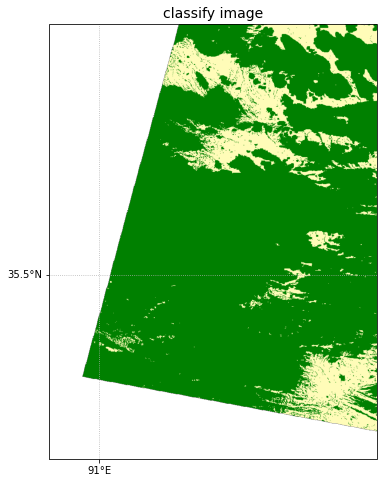

In [15]:
# 分类结果
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
region = [90.9343, 35.2597,91.3626, 35.8279] 
fig = plt.figure(figsize=(12, 8))
visParams = {'min':0,'max':2,'palette':['green','fffcb8','0905ff']}
ax = cartoee.get_map(classify_image,region=region,vis_params=visParams)
cartoee.add_gridlines(ax, interval=[0.5,0.5], linestyle=":")
ax.set_title(label = 'classify image', fontsize=14)

Text(0.5, 1.0, 'raw image')

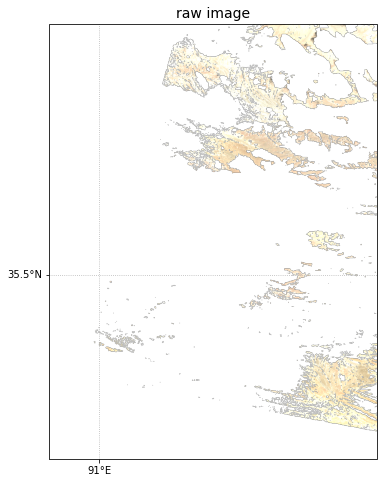

In [18]:
# 分类结果
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
region = [90.9343, 35.2597,91.3626, 35.8279] 
fig = plt.figure(figsize=(12, 8))
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
ax = cartoee.get_map(maskSR(image.clip(roi)),region=region,vis_params=visParams)
cartoee.add_gridlines(ax, interval=[0.5,0.5], linestyle=":")
ax.set_title(label = 'raw image', fontsize=14)

In [ ]:
invalidPixels = classify_image.eq(0).multiply(ee.Image.pixelArea()).divide(1e6)
invalidarea = invalidPixels.reduceRegion(**{'reducer': ee.Reducer.sum(),'geometry': roi,'scale': 200,'maxPixels': 1e14,'tileScale': 2}).get('waterclass')
region = classify_image.gte(0).multiply(ee.Image.pixelArea()).divide(1e6)
regionarea = region.reduceRegion(**{'reducer': ee.Reducer.sum(),'geometry': roi,'scale': 200,'maxPixels': 1e14,'tileScale': 2}).get('waterclass')
print(invalidarea.getInfo())
print(ee.Number(invalidarea).divide(ee.Number(regionarea)).getInfo())

In [ ]:
# 水体为0
'LANDSAT/LC08/C01/T1_SR/LC08_138035_20200406'
'LANDSAT/LC08/C01/T1_SR/LC08_138035_20200422'
'LANDSAT/LC08/C01/T1_SR/LC08_138035_20200524'

In [ ]:
# 不一致
'LANDSAT/LC08/C01/T1_SR/LC08_138035_20201031'
'LANDSAT/LC08/C01/T1_SR/LC08_139036_20200819'  
'LANDSAT/LC08/C01/T1_SR/LC08_140035_20201013' 
'LANDSAT/LC08/C01/T1_SR/LC08_140035_20201029' 
'LANDSAT/LC08/C01/T1_SR/LC08_140035_20201114'  
'LANDSAT/LC08/C01/T1_SR/LC08_140036_20200826'